In [ ]:
import numpy as np
from tqdm import tqdm 
from astropy.io import fits
from matplotlib import pyplot as plt
import aux_functions as a
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from photutils.centroids import centroid_quadratic

In [17]:
archivo = "M41.fits"
info_archivo = fits.info(archivo)

Filename: M41.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (3096, 2080)   float64   
  1                1 ImageHDU        36   (3096, 2080)   float64   
  2                1 ImageHDU        36   (3096, 2080)   float64   


In [ ]:
blue = fits.getdata(archivo,ext=0)
red = fits.getdata(archivo,ext=1)
green = fits.getdata(archivo,ext=2)

(2080, 3096)

In [90]:
t_exp = 25.0

In [ ]:
#MOSTRAR HISTOGRAMA DE CUENTAS
#plt.hist(red.ravel(),bins=500,log=True)

In [ ]:
#MOSTRAR IMAGEN
#plt.imshow(np.log10(red), origin='lower', cmap='magma', norm="log")
#plt.colorbar()

In [ ]:
#BUSCAR MAXIMOS
image_max = ndi.maximum_filter(red, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(red, min_distance=20)

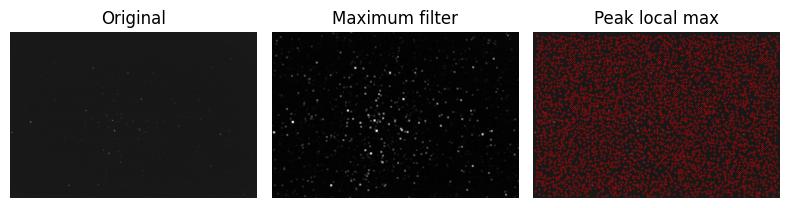

In [23]:
# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(red, cmap=plt.cm.gray, norm="log")
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray, norm="log")
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(red, cmap=plt.cm.gray, norm="log")
ax[2].autoscale(True)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.', markersize=0.5)
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()


In [24]:
centroides = np.zeros_like(coordinates, dtype=float)

for i, (y, x) in tqdm(enumerate(coordinates)):
    xcen, ycen = centroid_quadratic(red, xpeak=x, ypeak=y)
    centroides[i] = (xcen, ycen)

799it [00:35, 20.13it/s]WARNING: quadratic fit does not have a maximum [photutils.centroids.core]
3476it [02:32, 22.76it/s]


In [26]:
centroides.shape

(3476, 2)

In [35]:
centroides = centroides[np.any(centroides != 0, axis=1)]
centroides = centroides[np.all(np.isfinite(centroides), axis=1)]
centroides.shape


(2881, 2)

In [ ]:
#Apertura y anillo de cielo
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
positions = centroides
aperture = CircularAperture(positions, r=5) #Radio = 5 px
annulus = CircularAnnulus(positions, r_in=8, r_out=12)
phot_table = aperture_photometry(red, [aperture, annulus])
annulus_area = annulus.area
aperture_area = aperture.area
sky_mean = phot_table['aperture_sum_1'] / annulus_area
sky_total = sky_mean * aperture_area
flux = phot_table['aperture_sum_0'] - sky_total

In [38]:
prel_flux_red = flux
prel_positions_red = positions

Con unas estrellas preliminares halladas, buscamos el FWHM de las 30 más brillantes.

In [ ]:
idx_sorted = np.argsort(prel_flux_red)[::-1]  # de mayor a menor
coordinates_sorted = prel_positions_red[idx_sorted] #x,y
fluxes_sorted = prel_flux_red[idx_sorted]

ny, nx = red.shape

n_grid = 5
y_edges = np.linspace(0, ny, n_grid+1)
x_edges = np.linspace(0, nx, n_grid+1)

selected_coords = []
selected_fluxes = []

for i in range(n_grid):
    for j in range(n_grid):

        y_min, y_max = y_edges[i], y_edges[i+1]
        x_min, x_max = x_edges[j], x_edges[j+1]

        # estrellas dentro de la celda
        mask = (
            (coordinates_sorted[:,0] >= x_min) &
            (coordinates_sorted[:,0] <  x_max) &
            (coordinates_sorted[:,1] >= y_min) &
            (coordinates_sorted[:,1] <  y_max)
        )

        if np.any(mask):
            # como ya están ordenadas por brillo, la primera que aparece es la más brillante
            idx = np.where(mask)[0][0]
            selected_coords.append(coordinates_sorted[idx])
            selected_fluxes.append(fluxes_sorted[idx])

selected_fluxes = np.array(selected_fluxes)
selected_coords = np.array(selected_coords)

idx_top30 = np.argsort(selected_fluxes)[::-1][:30]

coords_final = selected_coords[idx_top30] #x,y
flux_final = selected_fluxes[idx_top30]

Text(0.5, 1.0, 'Top 30 positions')

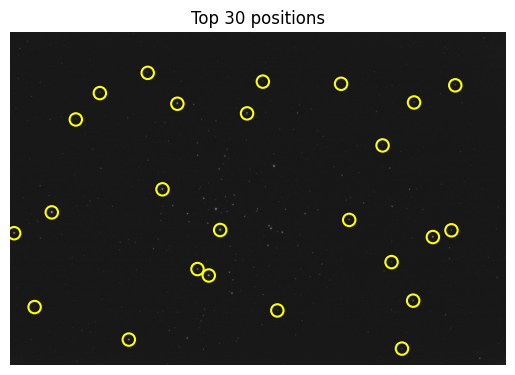

In [52]:
plt.imshow(red, cmap=plt.cm.gray, norm="log")
plt.autoscale(True)
plt.scatter(coords_final[:, 0], coords_final[:, 1],linewidths=1.5, edgecolors="yellow",facecolors='none', s=80)
plt.axis('off')
plt.title('Top 30 positions')

In [ ]:
from photutils.psf import fit_fwhm

fwhm_values = []
box_size = 19
for x0,y0 in tqdm(coords_final):
    half = box_size // 2
    y0 = int(y0)
    x0 = int(x0)

    stamp = red[
        y0-half:y0+half+1,
        x0-half:x0+half+1
    ]
    stamp = stamp - np.median(stamp)
    plt.imshow(stamp, cmap=plt.cm.gray, norm="log")
    plt.show()

    # evitar problemas en bordes
    if stamp.shape != (box_size, box_size):
        continue

    fwhm = fit_fwhm(stamp)
    fwhm_values.append(fwhm)

fwhm_array = np.array(fwhm_values)
print("FWHM medio:", np.mean(fwhm_array))
print("Desviación:", np.std(fwhm_array))
print("Porcentaje:", np.std(fwhm_array)/np.mean(fwhm_array))

100%|██████████| 25/25 [00:01<00:00, 23.22it/s]

FWHM medio: 2.9735007365636683
Desviación: 0.14910434436362316
Porcentaje: 0.050144377813719956


In [91]:
radio_apertura = 2.5*FWHM #2.5 - 4 FWHM 17.2 | 2-3 ANTES
r_in_sky = 3.5*FWHM #3.5 - 4
r_out_sky = 5.5*FWHM #5-6

positions_red = positions #x,y
aperture = CircularAperture(positions, r=radio_apertura) 
annulus = CircularAnnulus(positions, r_in=r_in_sky, r_out=r_out_sky)
phot_table = aperture_photometry(red, [aperture, annulus])
annulus_area = annulus.area
aperture_area = aperture.area
sky_mean = phot_table['aperture_sum_1'] / annulus_area
sky_total = sky_mean * aperture_area
flux = phot_table['aperture_sum_0'] - sky_total

flux_red = flux
mag_red = -2.5*np.log10(flux_red/t_exp)

C:\Users\japar\AppData\Local\Temp\ipykernel_25716\1878699138.py:16: RuntimeWarning: invalid value encountered in log10
  mag_red = -2.5*np.log10(flux_red/t_exp)


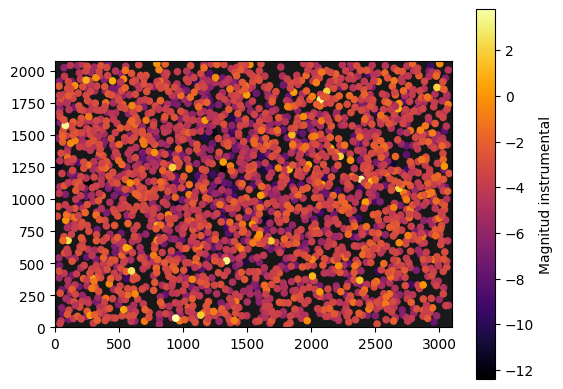

In [94]:
plt.imshow(red, cmap=plt.cm.gray, norm="log")
sc = plt.scatter(positions_red[:,0],   # x
                 positions_red[:,1],   # y
                 c=mag_red,           # color según flujo
                 s=20,
                 cmap='inferno')

plt.colorbar(sc, label='Magnitud instrumental')
plt.xlim(0, red.shape[1])
plt.ylim(0, red.shape[0])

plt.show()